# Read Fortran Binary Data Files

Although most of the data files I work with in atmosphere, ocean, and climate science are in self describing formats, such as netCDF, grib, etc, I still sometimes encounter binary data files written in fortran direct or sequential access.  I want to be able to read in these files and convert them to `xarray.Dataset` so I can use all the `xarray` methods and tools to process them.

This notebook will demonstrate how to read a fortran binary sequential access file and convert it to an `xarray.Dataset`

Thanks to Phil Pegion at University of Colorado/CIRES and NOAA/ESRL/PSD for showing me how to do this.

# Data

I was given the location of the following file from a colleague (Thanks David Straus!). It consists of EOFs (spatial patterns of variability) based on anomalies of 500 hPa geopotential height and 250 hPa zonal winds.  The file is located here on the COLA servers:
```/project/mjo/straus/ERAI_T42/eofs/DJF/5day_means/eofs_Z500U250_PNA_DJF_T42.1980-2014.dat```

A [GrADS](http://cola.gmu.edu/grads/) .ctl file was provided with the data.  It has the important metadata that will be needed to know how to read the file.  Here are its contents:

```
dset /project/mjo/straus/ERAI_T42/eofs/DJF/5day_means/eofs_Z500U250_PNA_DJF_T42.1980-2014.dat
undef -9999.9
title T42 gridded Minerva EOFs config Z500U250_PNA_DJF_T42
options sequential yrev 
xdef 128 linear 0.0 2.8125
ydef 64 LEVELS -87.86 -85.10 -82.31 -79.53 -76.74 -73.95 -71.16 -68.37
 -65.58 -62.79 -60.00 -57.21 -54.42 -51.63 -48.84 -46.04 -43.25 -40.46
 -37.67 -34.88 -32.09 -29.30 -26.51 -23.72 -20.93 -18.14 -15.35 -12.56
  -9.77  -6.98  -4.19  -1.40   1.40   4.19   6.98   9.77  12.56  15.35
  18.14  20.93  23.72  26.51  29.30  32.09  34.88  37.67  40.46  43.25
  46.04  48.84  51.63  54.42  57.21  60.00  62.79  65.58  68.37  71.16
  73.95  76.74  79.53  82.31  85.10  87.86
zdef 1 levels 1000
tdef 50 linear 01dec1980 1dy
vars 2
geo 0 9 geo 500
uwn 0 9 geo 250
endvars
```

The key things to note from the .ctl file are:
* lons = 128, start from 0.0 and increase in increments of 2.8125
* lats = 64 and are specified
* the file has 50 "times"; these correspond to 50 EOFs
* there are 2 variables in the file, geo (500 hPa geopotential height) and uwn (250 hPa zonal wind)
* under options, it says sequential, so our file is sequential access. This means that each record has 2 extra INTEGER*4 in it.  One at the beginning of the record and one at the end of the record.
* Missing data is indicated with values of -9999.9

The format of the data file is based on the format that GrADS expects, described [here (http://cola.gmu.edu/grads/gadoc/aboutgriddeddata.html#structure).  

Each record is a grid of all lats and lons. The records are in the following order:

1. Time 1, geo
2. Time 1, uwn
3. Time 2, geo
4. Time 2, uwn
5. ...

In [1]:
import numpy as np
from array import array
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

Define the path and filename

In [2]:
path='/project/mjo/straus/ERAI_T42/eofs/DJF/5day_means/'
fname='eofs_Z500U250_PNA_DJF_T42.1980-2014.dat'

Define the dimensions of the data based on the .ctl file

In [3]:
nlons=128
nlats=64
neofs=50
nvars=2
missing_value=-9999.9

Define the coordinates of the data based on the .ctl file

In [4]:
# Define lats
lats=[-87.86, -85.10, -82.31, -79.53, -76.74, -73.95, -71.16, -68.37, \
      -65.58, -62.79, -60.00, -57.21, -54.42, -51.63, -48.84, -46.04, \
      -43.25, -40.46, -37.67, -34.88, -32.09, -29.30, -26.51, -23.72, \
      -20.93, -18.14, -15.35, -12.56, -9.77,  -6.98,  -4.19,  -1.40, \
      1.40,   4.19,   6.98,   9.77,  12.56,  15.35,  18.14,  20.93, \
      23.72,  26.51,  29.30,  32.09,  34.88,  37.67,  40.46,  43.25, \
      46.04,  48.84,  51.63,  54.42,  57.21,  60.00,  62.79,  65.58, \
      68.37,  71.16,  73.95,  76.74,  79.53,  82.31,  85.10,  87.86]

# Yrev in .ctl file indicates lats are reversed
lats=lats[::-1]

# Define lons
lons=np.arange(128)*2.8125 + 0.0

# Define times as a pandas date range
eofs=np.arange(neofs)

Define the length of each record.  Be sure to include the 2 extra integers for sequential access.

In [5]:
recl=(nlons*nlats+2)*4

Create empty array to store the data

In [6]:
data=np.zeros((neofs,nlats,nlons,nvars))

Read the data

In [7]:
# Open file
luin = open(path+fname,'rb')

# Loop over all times
for e in range(neofs):
    
    # Loop over both variables
    for v in range(nvars):
        
        # Read in fortran record in bytes
        tmp=luin.read(recl) 
       
        # Convert to single precision (real 32bit)
        tmp1=array('f',tmp) 
        
        # Pull out data array (leaving behind fortran control records)for fortran sequential
        tmp2=tmp1[1:-1] 
        
        # Create a 2d array (lat x lon) and store it in the data array
        data[e,:,:,v]=np.reshape(tmp2,(nlats,nlons))  

Extract out our two variables

In [8]:
z500=data[:,:,:,0]
u250=data[:,:,:,1]

Take care of missing data by setting it to NAN

In [9]:
z500[z500<=missing_value]=np.nan
u250[u250<=missing_value]=np.nan

Put the data into an `xarray.Dataset`

In [10]:
# 500 hPa Geopotential Height
z500_ds=xr.DataArray(z500,
                coords={'eofnum':eofs,
                        'lat':lats,
                        'lon': lons},
                        dims=['eofnum','lat','lon'])        
z500_ds=z500_ds.to_dataset(name='z500')

# 250 hPa Zonal Wind
u250_ds=xr.DataArray(u250,
                coords={'eofnum':eofs,
                        'lat':lats,
                        'lon': lons},
                        dims=['eofnum','lat','lon'])        
u250_ds=u250_ds.to_dataset(name='u250')

# Merge to have both in the same `xarray.Dataset`
ds=xr.merge([z500_ds,u250_ds])

This dataset has global values, but only contains valid data in a certain region.  All other values are marked as missing. So, we will drop missing data for `lat` and `lon` where `all` the data are missing.

In [11]:
ds=ds.dropna(dim='lon',how='all').dropna(dim='lat',how='all')

Now we have an `xarray.Dataset` with both variables in it

In [12]:
ds

<xarray.Dataset>
Dimensions:  (eofnum: 50, lat: 22, lon: 55)
Coordinates:
  * eofnum   (eofnum) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 149.1 151.9 154.7 157.5 ... 292.5 295.3 298.1 300.9
Data variables:
    z500     (eofnum, lat, lon) float64 -0.002158 -0.002206 ... 0.02298 0.02562
    u250     (eofnum, lat, lon) float64 0.001532 0.001246 ... 0.0007635 -0.01382

Let's see what our data look like

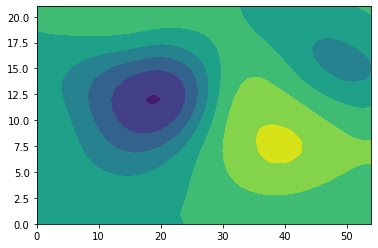

In [13]:
plt.contourf(ds['z500'][0,:,:])

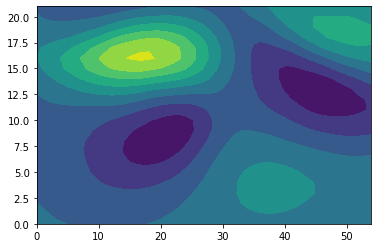

In [14]:
plt.contourf(ds['u250'][0,:,:])

Write our data out to a netcdf file

In [ ]:
ds.to_netcdf('eofs.nc')